# Setup 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
import numpy as np

# Prepare the Data

In [2]:
test = np.array([1, 2, 3])
test

array([1, 2, 3])

In [3]:
test.shape

(3,)

In [4]:
test2 = np.expand_dims(test, 1)
test2

array([[1],
       [2],
       [3]])

In [5]:
test2.shape

(3, 1)

In [6]:
# Prepare parameters
num_classes = 10
input_shape = (28, 28, 1)

# Split data between train and test sets
# Check if MNIST dataset exists or not (download MNIST and save at path relative to ~/.keras/datasets).
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
60000 train samples
10000 test samples


In [7]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

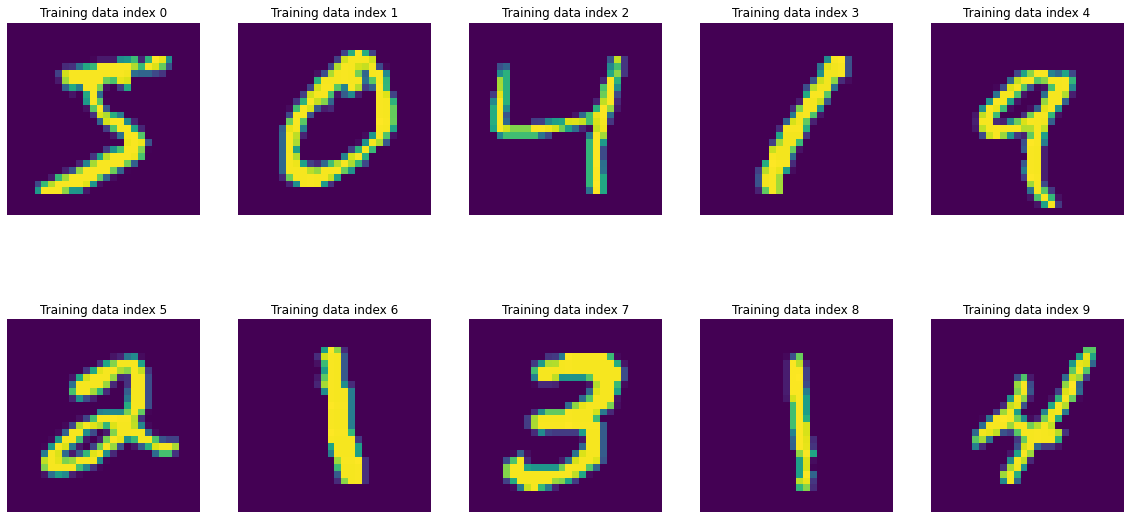

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(20,10))
for i in range(2):
    for j in range(5):
        axes[i, j].set_title("Training data index {}".format(i*5+j))
        axes[i, j].axis("off")
        axes[i, j].imshow(x_train[i*5+j].reshape(28, 28), cmap=None)
plt.show()

# Build the Model

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2)
csv_logger = CSVLogger('training.log')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

# Train the Model

In [10]:
# Prepare parameter
batch_size = 128
epochs = 20

# Fit the data
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.1,
                 callbacks=[es, csv_logger])

Epoch 1/20
422/422 [==============================] - 3s 4ms/step - loss: 0.6431 - accuracy: 0.8007 - val_loss: 0.0850 - val_accuracy: 0.9778
Epoch 2/20
422/422 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.9622 - val_loss: 0.0608 - val_accuracy: 0.9827
Epoch 3/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0900 - accuracy: 0.9739 - val_loss: 0.0478 - val_accuracy: 0.9880
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0714 - accuracy: 0.9775 - val_loss: 0.0420 - val_accuracy: 0.9882
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0592 - accuracy: 0.9806 - val_loss: 0.0393 - val_accuracy: 0.9902
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.0386 - val_accuracy: 0.9897
Epoch 7/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0499 - accuracy: 0.9839 - val_loss: 0.0363 - val_accuracy: 0.9903
Epoch 

# Evaluation

test loss: 0.030919374898076057
test acc: 0.9886000156402588


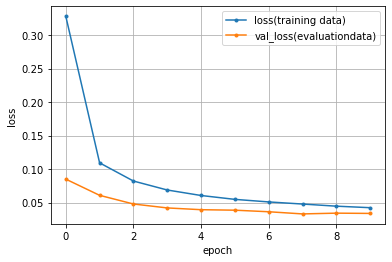

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', score[0])
print('test acc:', score[1])

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss(evaluationdata)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
import tensorflow as tf
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [13]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
tf.version.VERSION

'2.4.1'